<a href="https://colab.research.google.com/github/Ahmedzayan1/Speech_Emotion_Recognition/blob/main/SER_Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import preprocessing
import torch
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
import pickle
import gc
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

### 1.Download the Dataset and Understand the Format (10 Points)



1.  We will use CREMA dataset



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


SAD - sadness;
ANG - angry;
DIS - disgust;
FEA - fear;
HAP - happy;
NEU - neutral.

In [ ]:
!unzip gdrive/My\ Drive/Crema.zip

Streaming output truncated to the last 5000 lines.
  inflating: Crema/1088_IWW_FEA_XX.wav  
  inflating: Crema/1088_IWW_HAP_XX.wav  
  inflating: Crema/1088_IWW_NEU_XX.wav  
  inflating: Crema/1088_IWW_SAD_XX.wav  
  inflating: Crema/1088_MTI_ANG_XX.wav  
  inflating: Crema/1088_MTI_DIS_XX.wav  
  inflating: Crema/1088_MTI_FEA_XX.wav  
  inflating: Crema/1088_MTI_HAP_XX.wav  
  inflating: Crema/1088_MTI_NEU_XX.wav  
  inflating: Crema/1088_MTI_SAD_XX.wav  
  inflating: Crema/1088_TAI_ANG_XX.wav  
  inflating: Crema/1088_TAI_DIS_XX.wav  
  inflating: Crema/1088_TAI_FEA_XX.wav  
  inflating: Crema/1088_TAI_HAP_XX.wav  
  inflating: Crema/1088_TAI_NEU_XX.wav  
  inflating: Crema/1088_TAI_SAD_XX.wav  
  inflating: Crema/1088_TIE_ANG_XX.wav  
  inflating: Crema/1088_TIE_DIS_XX.wav  
  inflating: Crema/1088_TIE_FEA_XX.wav  
  inflating: Crema/1088_TIE_HAP_XX.wav  
  inflating: Crema/1088_TIE_NEU_XX.wav  
  inflating: Crema/1088_TIE_SAD_XX.wav  
  inflating: Crema/1088_TSI_ANG_XX.wav  
  infl

In [ ]:
Crema_Path='/content/Crema'

In [ ]:
crema=[]
for wav in os.listdir(Crema_Path):
    emotion=wav.partition(".wav")[0].split('_')
    if emotion[2]=='SAD':
        crema.append(('sad',Crema_Path+'/'+wav))
    elif emotion[2]=='ANG':
        crema.append(('angry',Crema_Path+'/'+wav))
    elif emotion[2]=='DIS':
        crema.append(('disgust',Crema_Path+'/'+wav))
    elif emotion[2]=='FEA':
        crema.append(('fear',Crema_Path+'/'+wav))
    elif emotion[2]=='HAP':
        crema.append(('happy',Crema_Path+'/'+wav))
    elif emotion[2]=='NEU':
        crema.append(('neutral',Crema_Path+'/'+wav))
    else:
        crema.append(('unknown',Crema_Path+'/'+wav))
Crema_df=pd.DataFrame.from_dict(crema)
Crema_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Crema_df.head()

,Emotion,File_Path
0,angry,/content/Crema/1066_IOM_ANG_XX.wav
1,fear,/content/Crema/1066_ITH_FEA_XX.wav
2,disgust,/content/Crema/1085_ITS_DIS_XX.wav
3,neutral,/content/Crema/1068_IEO_NEU_XX.wav
4,sad,/content/Crema/1023_TSI_SAD_XX.wav


In [ ]:
Crema_df['Emotion'].value_counts()

angry      1271
fear       1271
disgust    1271
sad        1271
happy      1271
neutral    1087
Name: Emotion, dtype: int64

<Axes: xlabel='Emotion'>

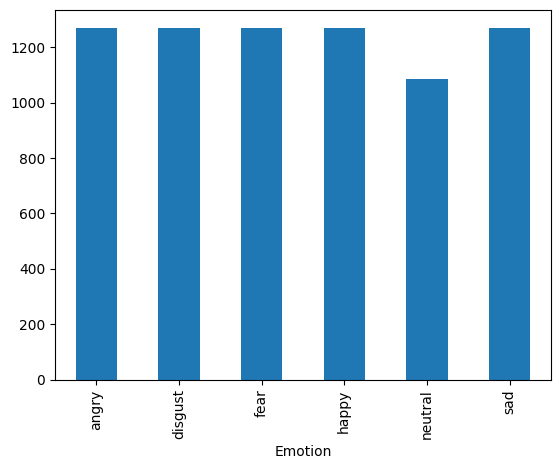

In [ ]:
Crema_df.groupby(['Emotion']).size().plot.bar()

In [ ]:
Crema_df['Emotion'].unique()

array(['angry', 'fear', 'disgust', 'neutral', 'sad', 'happy'],
      dtype=object)


2.  Write your own function that loads an audio and listen to each of the classes you have and plot the waveform of the audio.

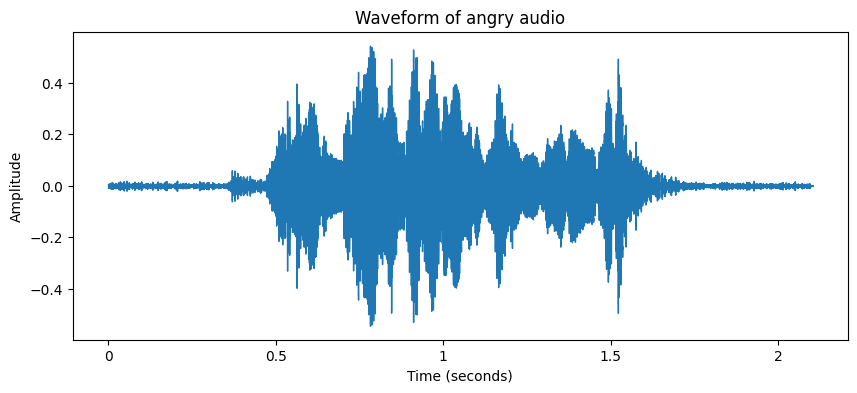

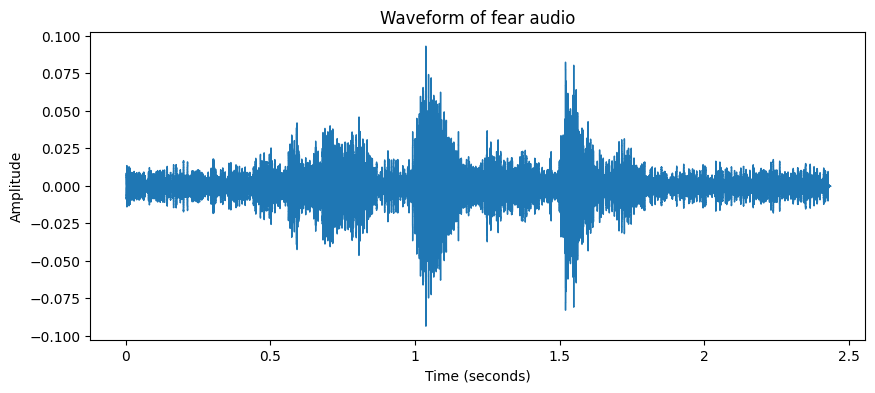

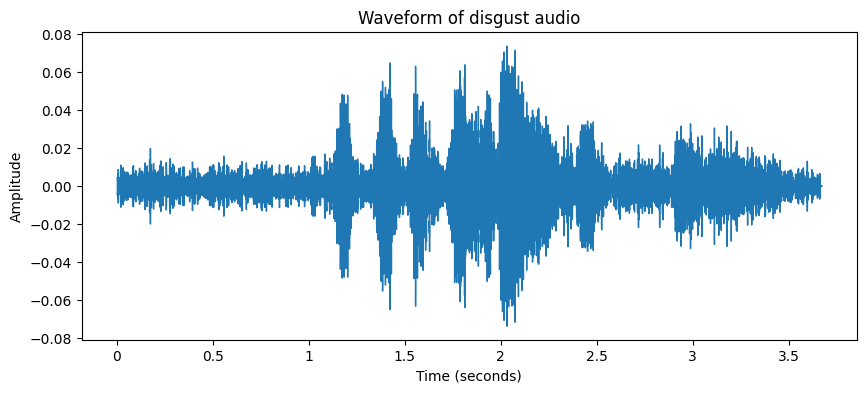

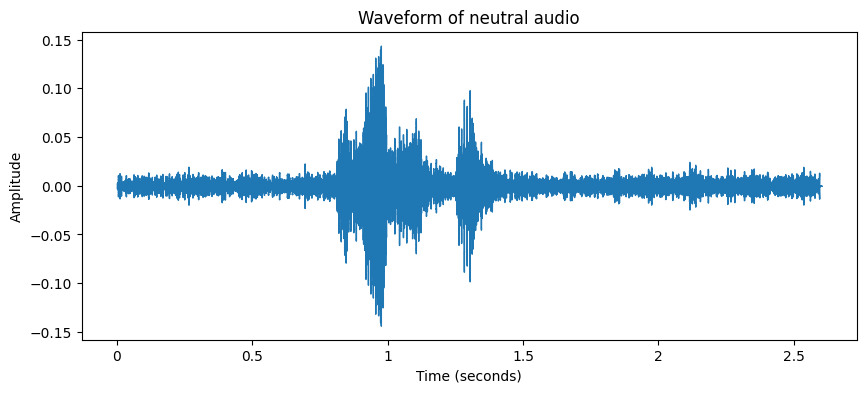

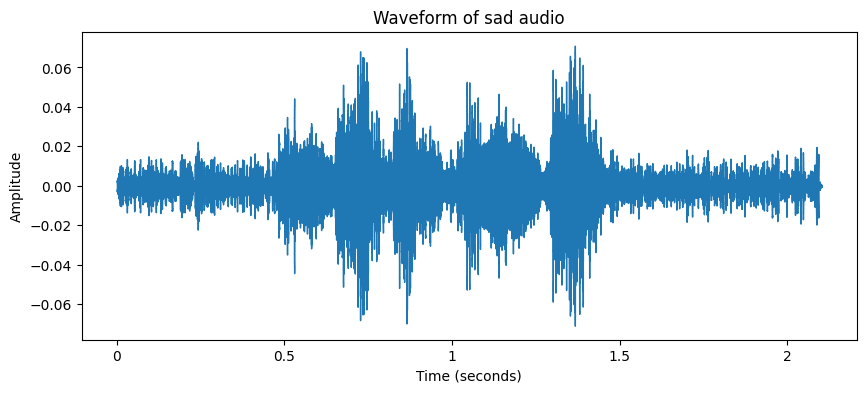

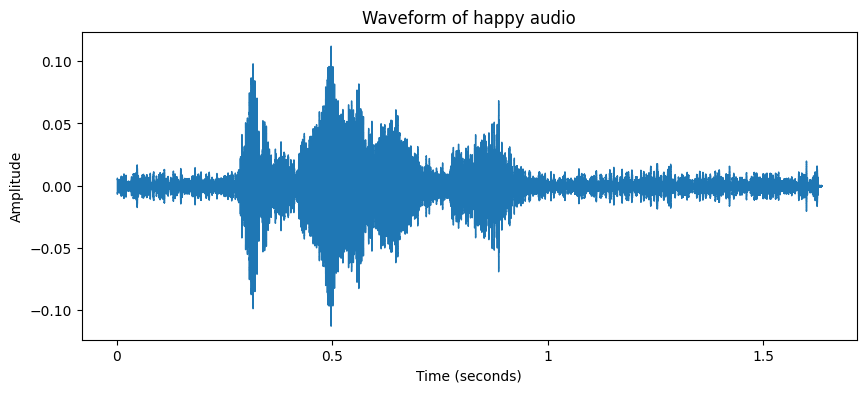

In [ ]:
# loop through each class in the dataframe
for cls in Crema_df['Emotion'].unique():

  # select the rows corresponding to the current class
  class_rows = Crema_df[Crema_df['Emotion'] == cls]

  # loop through each audio file in the current class
  for file_path in class_rows['File_Path']:

    # load the audio file using librosa
    audio_data, sr = librosa.load(file_path, sr=None)

    # plot the waveform of the audio file
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio_data, sr=sr)
    plt.title(f'Waveform of {cls} audio')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.show()

    # listen to the audio file
    ipd.display(ipd.Audio(audio_data, rate=sr))
    break

### 2.Create the Feature Space (30 Points)

We will create two feature spaces from the audio.

a.time domain.

1.    Zero crossing rate: The rate of sign-changes of the signal during the duration of a particular frame.
2.    Energy: The sum of squares of the signal values, normalized by the respective frame length.

In [ ]:
Crema_df.head()

,File_Path,Emotion
0,/content/Crema/1062_DFA_HAP_XX.wav,happy
1,/content/Crema/1084_WSI_HAP_XX.wav,happy
2,/content/Crema/1014_IEO_FEA_LO.wav,fear
3,/content/Crema/1054_WSI_HAP_XX.wav,happy
4,/content/Crema/1090_IEO_HAP_MD.wav,happy


b.adding features

In [ ]:
def add_noise(data,random=False,rate=0.035,threshold=0.075):
    if random:
        rate=np.random.random()*threshold
    noise=rate*np.random.uniform()*np.amax(data)
    augmented_data=data+noise*np.random.normal(size=data.shape[0])
    return augmented_data

def shifting(data,rate=1000):
    augmented_data=int(np.random.uniform(low=-5,high=5)*rate)
    augmented_data=np.roll(data,augmented_data)
    return augmented_data

def pitching(data,sr,pitch_factor=0.7,random=False):
    if random:
        pitch_factor=np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(data,sr=sr, n_steps=pitch_factor)

def streching(data,rate=0.8):
    return librosa.effects.time_stretch(data,rate)

def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data,sr)
    audio=np.array(aud)

    noised_audio=add_noise(data,random=True)
    aud2=extract_features(noised_audio,sr)
    audio=np.vstack((audio,aud2))

    pitched_audio=pitching(data,sr,random=True)
    aud3=extract_features(pitched_audio,sr)
    audio=np.vstack((audio,aud3))

    pitched_audio1=pitching(data,sr,random=True)
    pitched_noised_audio=add_noise(pitched_audio1,random=True)
    aud4=extract_features(pitched_noised_audio,sr)
    audio=np.vstack((audio,aud4))

    return audio

In [ ]:
X,Y=[],[]
for index, row in Crema_df.iterrows():
    path = row['File_Path']
    emotion = row['Emotion']
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')

0 audio has been processed
500 audio has been processed
1000 audio has been processed
1500 audio has been processed
2000 audio has been processed
2500 audio has been processed
3000 audio has been processed
3500 audio has been processed
4000 audio has been processed
4500 audio has been processed
5000 audio has been processed
5500 audio has been processed
6000 audio has been processed
6500 audio has been processed
7000 audio has been processed
Done


In [ ]:
extract=pd.DataFrame(X)
extract['Emotion']=Y
processed_data_path='./processed_data.csv'
extract.to_csv(processed_data_path,index=False)
extract.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotion
0,0.032715,0.042969,0.047852,0.044434,0.053223,0.068848,0.093750,0.108398,0.096191,0.080566,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,angry
1,0.045410,0.072266,0.089844,0.090332,0.095215,0.096191,0.109375,0.118164,0.103027,0.090332,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,angry
2,0.030273,0.037598,0.043457,0.042969,0.055664,0.081543,0.104980,0.114258,0.104004,0.080078,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,angry
3,0.038086,0.051270,0.066406,0.075195,0.081543,0.101562,0.116699,0.116211,0.106445,0.083496,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,angry
4,0.022461,0.042969,0.058594,0.064941,0.077637,0.074707,0.077148,0.075684,0.065918,0.054688,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
5,0.031250,0.055664,0.071289,0.075684,0.082520,0.077637,0.083984,0.083496,0.079590,0.067383,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
6,0.022949,0.038574,0.051270,0.057129,0.063477,0.067871,0.067383,0.067383,0.057129,0.046875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
7,0.022461,0.039062,0.048828,0.053223,0.061035,0.063965,0.068359,0.067871,0.056152,0.044922,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
8,0.008789,0.014648,0.017578,0.017090,0.017090,0.015625,0.016113,0.016602,0.016113,0.016113,...,-4.755392,-4.368697,-2.920816,8.019663,-2.307033,11.618562,-5.977792,-3.279551,-9.615792,disgust
9,0.108398,0.183594,0.251465,0.240723,0.226074,0.196777,0.165527,0.147461,0.187988,0.203125,...,5.810787,-4.287134,-0.727638,5.282607,2.842929,-1.405196,-2.376917,-1.274522,-6.060073,disgust


In [ ]:
alter=extract

In [ ]:
alter.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotion
0,0.032715,0.042969,0.047852,0.044434,0.053223,0.068848,0.093750,0.108398,0.096191,0.080566,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,angry
1,0.045410,0.072266,0.089844,0.090332,0.095215,0.096191,0.109375,0.118164,0.103027,0.090332,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,angry
2,0.030273,0.037598,0.043457,0.042969,0.055664,0.081543,0.104980,0.114258,0.104004,0.080078,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,angry
3,0.038086,0.051270,0.066406,0.075195,0.081543,0.101562,0.116699,0.116211,0.106445,0.083496,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,angry
4,0.022461,0.042969,0.058594,0.064941,0.077637,0.074707,0.077148,0.075684,0.065918,0.054688,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear


In [ ]:
alter.dropna(axis=1, inplace=True)

In [ ]:
alter.head()

In [ ]:
files.download('alter.csv')

In [ ]:
from google.colab import files
alter.to_csv('alter.csv',encoding = 'utf-8-sig')
files.download('alter.csv')
extract.to_csv('extract.csv',encoding = 'utf-8-sig')
files.download('extract.csv')

In [ ]:
extract.to_csv('/content/drive/Mydrive/cremaextracted/extract.csv',encoding = 'utf-8-sig')

In [ ]:
X=alter.drop(labels='Emotion',axis=1)
Y=alter['Emotion']

In [ ]:
lb=preprocessing.LabelEncoder()
Y=np_utils.to_categorical(lb.fit_transform(Y))
print(lb.classes_)
Y

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']


array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [ ]:
X.shape,Y.shape

((29768, 638), (29768, 6))

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,random_state=42,test_size=0.3,shuffle=True)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((20837, 638), (8931, 638), (20837, 6), (8931, 6))

In [ ]:
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,random_state=42,test_size=0.051,shuffle=True)
X_train.shape, X_test.shape, X_val.shape, y_train.shape,y_test.shape,y_val.shape


((19774, 638), (8931, 638), (1063, 638), (19774, 6), (8931, 6), (1063, 6))

In [ ]:
X_train=np.expand_dims(X_train,axis=2)
X_val=np.expand_dims(X_val,axis=2)
X_test=np.expand_dims(X_test,axis=2)
X_train.shape, X_test.shape, X_val.shape

((19774, 638, 1), (8931, 638, 1), (1063, 638, 1))

### 3.Building the Model (40 Points)


In [ ]:
# y=Crema_df.drop('File_Path',axis=1)
# y=y.drop('zcr',axis=1)
# y=y.drop('energy',axis=1)
# X=Crema_df.drop('Emotion',axis=1)
# X=X.drop('File_Path',axis=1)

In [ ]:
# y.head()

,Emotion
0,happy
1,happy
2,fear
3,happy
4,happy


In [ ]:
# le = preprocessing.LabelEncoder()
# y= le.fit_transform(y['Emotion'])
# y=pd.DataFrame(y, columns = ['Emotion'])

In [ ]:
# y.head()

,Emotion
0,3
1,3
2,2
3,3
4,3


1.  Split the data into 70% training and validation and 30% testing.


In [ ]:
# # Split data into train and test sets, stratified by y
# X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)


2.   Use  5%  of  the  training  and  validation  data  for validation.
  




In [ ]:
# # Split train and validation sets, and use 5% of the training data for validation
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.05, stratify=y_train_val, random_state=42)

In [ ]:
# y_train.value_counts()

Emotion
0          845
1          845
2          845
3          845
5          845
4          723
dtype: int64

In [ ]:
# y_val.value_counts()

Emotion
1          45
2          45
5          45
0          44
3          44
4          38
dtype: int64

In [ ]:
# y_test.value_counts()

Emotion
0          382
3          382
1          381
2          381
5          381
4          326
dtype: int64

3.  CNN Model:

Build  a  CNN  architecture  of  your  own  For the time domain or frequency domain feature space will be 1 dimensional, therefore in the architecture we will be using 1D convolutions.


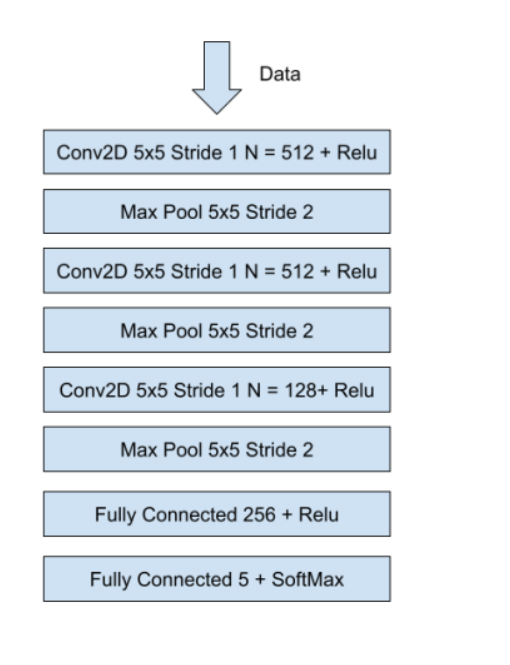

# **cnn ** #

In [ ]:
import IPython
import tensorflow.keras.layers as L
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import np_utils
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
X_train

,zcr,energy
1415,0.105167,180.643921
5498,0.047321,6.088320
2407,0.108558,5.895176
4607,0.052289,11.141132
4139,0.067942,30.063423
...,...,...
3261,0.047824,10.299311
1766,0.040227,6.451409
4144,0.093763,958.008301
3183,0.091610,12.723675


In [ ]:
model=tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(6,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 638, 512)          3072      
                                                                 
 batch_normalization_18 (Bat  (None, 638, 512)         2048      
 chNormalization)                                                
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 319, 512)         0         
 g1D)                                                            
                                                                 
 conv1d_16 (Conv1D)          (None, 319, 512)          1311232   
                                                                 
 batch_normalization_19 (Bat  (None, 319, 512)         2048      
 chNormalization)                                                
                                                      

In [ ]:
early_stop=EarlyStopping(monitor='val_accuracy',mode='auto',patience=10,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.00001)
# monitor='val_acc': The validation accuracy is monitored.
# mode='auto': The callback determines the direction of improvement automatically based on the monitored quantity (accuracy in this case).
# patience=5: Training will be stopped if there is no improvement in validation accuracy for 5 consecutive epochs.
# restore_best_weights=True: The model will restore the weights from the epoch with the best validation accuracy.
# The ReduceLROnPlateau callback is defined with the following arguments:

# monitor='val_acc': The validation accuracy is monitored.
# patience=3: The learning rate will be reduced if there is no improvement in validation accuracy for 3 consecutive epochs.
# verbose=1: Information about the learning rate reduction will be printed.
# factor=0.5: The learning rate will be reduced by a factor of 0.5 when triggered.
# min_lr=0.00001: The minimum learning rate that can be reached.

In [ ]:
#epochs: This specifies the number of epochs (complete passes through the entire training dataset) for training the model.
#(X_val, y_val) representing the validation data. It is used to evaluate the model's performance on a separate dataset during training. X_val and y_val are similar to X_train and y_train, but they represent the validation set.
#batch_size: This specifies the number of samples to use in each batch during training. The model's weights are updated after each batch.
#callbacks: This is a list of callbacks to apply during training. Callbacks are objects that can perform actions at various stages during training, such as early stopping or learning rate reduction. In this case, the early_stop and lr_reduction callbacks are provided.
#
cnn_train=model.fit(X_train, y_train, epochs=50, validation_data=(X_val,y_val), batch_size=64,callbacks=[early_stop,lr_reduction])

Epoch 1/50
309/309 [==============================] - 37s 96ms/step - loss: 1.5640 - accuracy: 0.3741 - val_loss: 1.6018 - val_accuracy: 0.3810 - lr: 0.0010
Epoch 2/50
309/309 [==============================] - 28s 91ms/step - loss: 1.4441 - accuracy: 0.4129 - val_loss: 1.5096 - val_accuracy: 0.3819 - lr: 0.0010
Epoch 3/50
309/309 [==============================] - 27s 89ms/step - loss: 1.3976 - accuracy: 0.4279 - val_loss: 1.5458 - val_accuracy: 0.3622 - lr: 0.0010
Epoch 4/50
309/309 [==============================] - 28s 89ms/step - loss: 1.3698 - accuracy: 0.4450 - val_loss: 1.6211 - val_accuracy: 0.3650 - lr: 0.0010
Epoch 5/50
309/309 [==============================] - ETA: 0s - loss: 1.3329 - accuracy: 0.4614
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
309/309 [==============================] - 28s 90ms/step - loss: 1.3329 - accuracy: 0.4614 - val_loss: 1.5285 - val_accuracy: 0.3772 - lr: 0.0010
Epoch 6/50
309/309 [==============================] - 

In [ ]:
emotion_names = Crema_df['Emotion'].unique()

In [ ]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff

In [ ]:
fig=px.line(cnn_train.history,y=['accuracy','val_accuracy'],
           labels={'index':'epoch','value':'accuracy'},
           title=f'According to the epoch accuracy and validation accuracy chart for the model')
fig.show()

In [ ]:
fig=px.line(cnn_train.history,y=['loss','val_loss'],
           labels={'index':'epoch','value':'loss'},
           title=f'According to the epoch loss and validation loss chart for the model')
fig.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred

280/280 [==============================] - 4s 13ms/step


array([5, 2, 2, ..., 1, 3, 2])

In [ ]:
y_check=np.argmax(y_test,axis=1)
y_check

array([5, 2, 2, ..., 2, 3, 2])

In [ ]:
loss,accuracy=model.evaluate(X_test,y_test,verbose=0)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Test Loss: 0.27771830558776855
Test Accuracy: 0.937856912612915


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

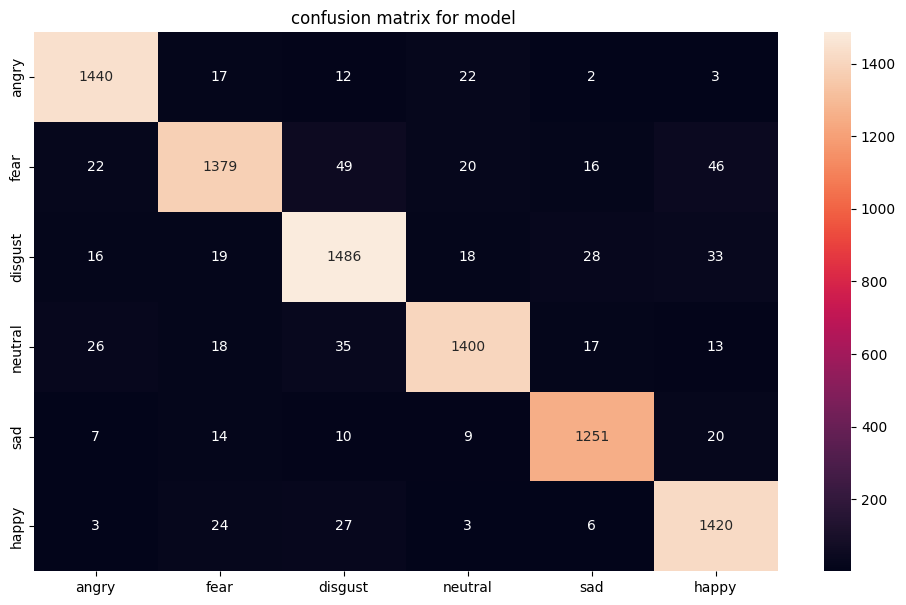

In [ ]:
conf=confusion_matrix(y_check,y_pred)
cm=pd.DataFrame(
    conf,index=[i for i in emotion_names],
    columns=[i for i in emotion_names]
)
plt.figure(figsize=(12,7))
ax=sns.heatmap(cm,annot=True,fmt='d')
ax.set_title(f'confusion matrix for model ')
plt.show()



In [ ]:
print(f'Model Confusion Matrix\n',classification_report(y_check,y_pred,target_names=emotion_names))

Model Confusion Matrix
               precision    recall  f1-score   support

       angry       0.95      0.96      0.96      1496
        fear       0.94      0.90      0.92      1532
     disgust       0.92      0.93      0.92      1600
     neutral       0.95      0.93      0.94      1509
         sad       0.95      0.95      0.95      1311
       happy       0.93      0.96      0.94      1483

    accuracy                           0.94      8931
   macro avg       0.94      0.94      0.94      8931
weighted avg       0.94      0.94      0.94      8931



In [ ]:
model.save('/content/gdrive/My Drive/pra3/model_{}.h5'.format(50))